In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
%matplotlib inline

In [2]:
x, y = load_digits(return_X_y = True)
x.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [4]:
m = len(y) // 2
x_train, x_test = x[:m], x[m:m*2]
y_train, y_test = y[:m], y[m:m*2]
x_train = np.reshape(x_train, [-1, 8, 8])
x_test = np.reshape(x_test, [-1, 8, 8])
x_train.shape, y_train.shape

((898, 8, 8), (898,))

In [6]:
x_train_l, x_train_r = np.split(x_train, 2, axis=0) 
x_train_lr = np.concatenate((x_train_l, x_train_r), axis=2)
y_train_l, y_train_r = np.split(y_train, 2, axis=0) 
y_train = np.stack((y_train_l, y_train_r), -1)
x_train_lr.shape, y_train.shape

((449, 8, 16), (449, 2))

In [7]:
x_test_l, x_test_r = np.split(x_test, 2, axis=0) 
x_test_lr = np.concatenate((x_test_l, x_test_r), axis=2)
y_test_l, y_test_r = np.split(y_test, 2, axis=0) 
y_test = np.stack((y_test_l, y_test_r), -1)
x_test_lr.shape, y_test.shape

((449, 8, 16), (449, 2))

train

In [11]:
BLANK = 10 #'없음' 을 나타내는 기호
x_train_blank = np.concatenate((x_train_l, np.zeros_like(x_train_r)), axis=2)
y_train_blank = np.stack((y_train_l, np.zeros_like(y_train_l) + BLANK), 1)#좌측 영상의 y와 빈 영상의 y를 통합

In [12]:
x_train_set = np.concatenate((x_train_lr, x_train_blank), 0)# 두자리수 영상과 한자리수 영상을 통합
y_train_set = np.concatenate((y_train, y_train_blank), 0)#두자리수 y와 한자리수 y 를 통합
x_train_set.shape, y_train_set.shape

((898, 8, 16), (898, 2))

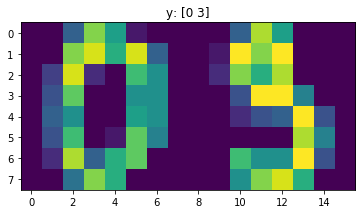

In [15]:
i = 0
plt.title('y: '+str(y_train_set[i]))
plt.imshow(x_train_set[i].reshape((8,-1)))

test

In [13]:
BLANK = 10 #'없음' 을 나타내는 기호
x_test_blank = np.concatenate((x_test_l, np.zeros_like(x_test_r)), axis=2)
y_test_blank = np.stack((y_test_l, np.zeros_like(y_test_l) + BLANK), 1)#좌측 영상의 y와 빈 영상의 y를 통합

In [14]:
x_test_set = np.concatenate((x_test_lr, x_test_blank), 0)# 두자리수 영상과 한자리수 영상을 통합
y_test_set = np.concatenate((y_test, y_test_blank), 0)#두자리수 y와 한자리수 y 를 통합
x_test_set.shape, y_test_set.shape

((898, 8, 16), (898, 2))

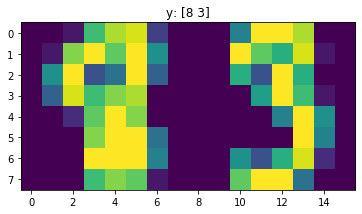

In [16]:
i = 0
plt.title('y: '+str(y_test_set[i]))
plt.imshow(x_test_set[i].reshape((8,-1)))

In [32]:
class MyModel(keras.Model):
    def __init__(self):    
        super(MyModel, self).__init__()
        self.k = 10+1 # 클래스 갯수 
        self.seq = 2 # 자릿수
        self.opt = tf.optimizers.Nadam()#Stochatic Gradient Descent 확률적 경사 하강
        self.conv0 = keras.layers.Conv2D(128, [3,3], padding='same', activation=keras.activations.relu)
        self.conv1 = keras.layers.Conv2D(128, [3,3], padding='same', activation=keras.activations.relu)
        self.pool0 = keras.layers.MaxPool2D([2,2], padding='same')
        self.pool1 = keras.layers.MaxPool2D([2,2], padding='same')
        self.flatten = keras.layers.Flatten()
        self.drop0 = keras.layers.Dropout(0.5)
        self.drop1 = keras.layers.Dropout(0.5)
        self.batch0 = keras.layers.BatchNormalization()
        self.batch1 = keras.layers.BatchNormalization()
        self.dense0 = keras.layers.Dense(64)
        self.batch2 = keras.layers.BatchNormalization()
        self.dense = keras.layers.Dense(units=self.k * self.seq)
  
    def call(self, x):
        #x (1797, 64)
        x_4d = tf.reshape(x, [-1,8,8*2,1]) 
        x_4d = tf.cast(x_4d, tf.float32)
        net = self.conv0(x_4d)
        net = self.batch0(net)
        net = self.pool0(net)
        net = self.drop0(net)
        net = self.conv1(net)
        net = self.batch1(net)
        net = self.pool1(net)
        net = self.drop1(net)
        net = self.flatten(net)
        net = self.dense0(net)
        net = self.batch2(net)
        h = self.dense(net)
        h = tf.reshape(h, [-1, self.seq, self.k]) # 2:두자리수, 10:10개의 클래스 
        h = tf.nn.softmax(h, axis=2)
        return h
    
    def get_loss(self, y, h):
        #학습할때 nan이 발생하는 경우 값을 clip(자르다) (최소값, 최대값) 
        h = tf.clip_by_value(h, 1e-8, 1 - 1e-8) # h 가 0이나 1이 되지 않도록 하는 안전장치 
        cross_entropy = - (y * tf.math.log(h) + (1 - y) * tf.math.log(1 - h)) 
        loss = tf.reduce_mean(cross_entropy)
        return loss

    def get_accuracy(self, y, h):    
        predict = tf.argmax(h, -1)
        is_equal = tf.equal(y, predict)
        self.acc = tf.reduce_mean(tf.cast(is_equal, tf.float32)) # True > 1, False > 0 로 cast
        self.acc_all = tf.reduce_mean(tf.cast(tf.reduce_all(is_equal, axis=1), tf.float32))

    def fit(self, x, y, epoch=1):
        # x : (m, 8, 16), y: (m, 2)    
        y_hot = tf.one_hot(y, depth=self.k, axis=-1)#(m, 2, 10)  
        for i in range(epoch):
            with tf.GradientTape() as tape: #경사 기록 장치
                h = self.call(x)
                loss = self.get_loss(y_hot, h)        
            grads = tape.gradient(loss, self.trainable_variables) #경사 계산
            self.opt.apply_gradients(zip(grads, self.trainable_variables)) # 가중치에서 경사를 빼기
            self.get_accuracy(y, h)
            if i%10==0:
                print('%d/%d loss:%.3f acc:%.3f acc_all:%.3f'%(i, epoch, loss, self.acc, self.acc_all))
model = MyModel()

In [33]:
model.fit(x_train_set, y_train_set, epoch=100) #학습

0/100 loss:0.446 acc:0.077 acc_all:0.002
10/100 loss:0.179 acc:0.614 acc_all:0.432
20/100 loss:0.137 acc:0.767 acc_all:0.592
30/100 loss:0.047 acc:0.932 acc_all:0.869
40/100 loss:0.019 acc:0.986 acc_all:0.972
50/100 loss:0.011 acc:0.987 acc_all:0.973
60/100 loss:0.004 acc:1.000 acc_all:1.000
70/100 loss:0.003 acc:1.000 acc_all:1.000
80/100 loss:0.002 acc:1.000 acc_all:1.000
90/100 loss:0.001 acc:1.000 acc_all:1.000


In [34]:
# 테스트셋의 성능
h = model(x_test_set)
model.get_accuracy(y_test_set, h)
print('개별정확도',model.acc.numpy(),'두자리 모두 맞춘 정확도', model.acc_all.numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

개별정확도 0.9404232 두자리 모두 맞춘 정확도 0.8841871
